# SAE-67: Dashboard Profils & Comportements des Reviewers

**Objectif** : Comprendre le profil des utilisateurs (Sévérité, Loquacité) selon leur expérience.

**Données** : `users_clean.parquet` et `reviews_clean.parquet`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
os.makedirs('../outputs/figures', exist_ok=True)

## 1. Chargement des données

In [2]:
users_path = '../data/cleaned/users_clean.parquet'
reviews_path = '../data/cleaned/reviews_clean.parquet'

print("Chargement des users...")
df_users = pd.read_parquet(users_path)
print(f"Users: {df_users.shape}")

print("Chargement des reviews...")
# On charge un sous-ensemble si nécessaire pour la RAM, mais parquet est efficace
# Pour l'analyse 'Level of Detail', on a besoin du texte ou au moins de sa longueur.
# Si 'text_length' est déjà dans cleaned, top. Sinon on calcule.
df_reviews = pd.read_parquet(reviews_path, columns=['review_id', 'user_id', 'stars', 'text'])
print(f"Reviews: {df_reviews.shape}")

# Calcul longueur texte si pas présent (normalement text est brut)
if 'text_length' not in df_reviews.columns:
    df_reviews['text_length'] = df_reviews['text'].str.len()

Chargement des users...


Users: (558095, 22)
Chargement des reviews...


Reviews: (999985, 4)


## 2. Segmentation des Reviewers

In [3]:
def segment_reviewer(count):
    if count < 5: return 'Novice'
    elif count < 20: return 'Amateur'
    elif count < 50: return 'Régulier'
    else: return 'Expert'

df_users['reviewer_type'] = df_users['review_count'].apply(segment_reviewer)

print("Répartition des profils :")
print(df_users['reviewer_type'].value_counts())

Répartition des profils :
reviewer_type
Amateur     209717
Novice      165372
Régulier     93932
Expert       89074
Name: count, dtype: int64


## 3. Analyse Sévérité (Stars vs Type)

C:\Users\melou\AppData\Local\Temp\ipykernel_760\3409358509.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=severity, x='reviewer_type', y='stars', order=order, palette='magma')


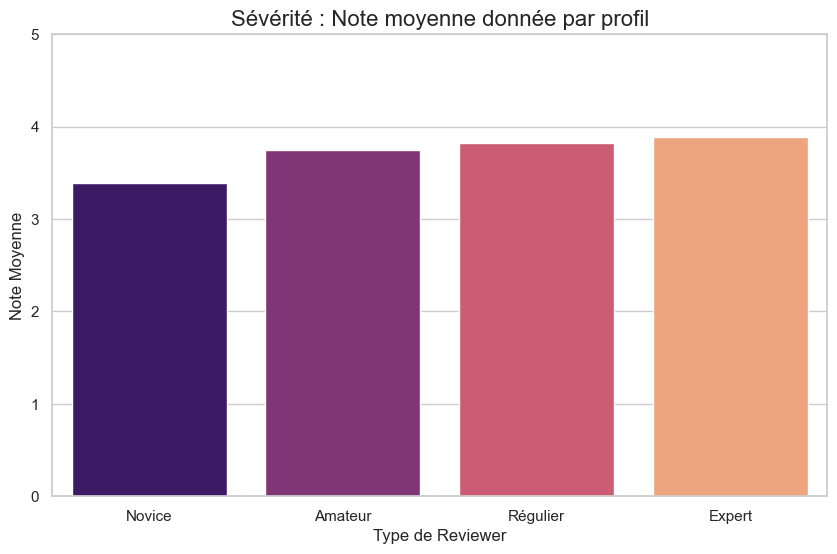

In [4]:
# Jointure pour associer chaque review au type de son auteur
df_merged = df_reviews.merge(df_users[['user_id', 'reviewer_type', 'average_stars']], on='user_id', how='inner')

# Note moyenne donnée par type
severity = df_merged.groupby('reviewer_type')['stars'].mean().reset_index()

# Ordre
order = ['Novice', 'Amateur', 'Régulier', 'Expert']

plt.figure(figsize=(10, 6))
sns.barplot(data=severity, x='reviewer_type', y='stars', order=order, palette='magma')
plt.title('Sévérité : Note moyenne donnée par profil', fontsize=16)
plt.ylim(0, 5)
plt.xlabel('Type de Reviewer')
plt.ylabel('Note Moyenne')
plt.savefig('../outputs/figures/sae67_severity_by_profile.png')
plt.show()

## 4. Analyse Loquacité (Longueur vs Expérience)

C:\Users\melou\AppData\Local\Temp\ipykernel_760\549440479.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=loquacity, x='reviewer_type', y='text_length', order=order, palette='viridis')


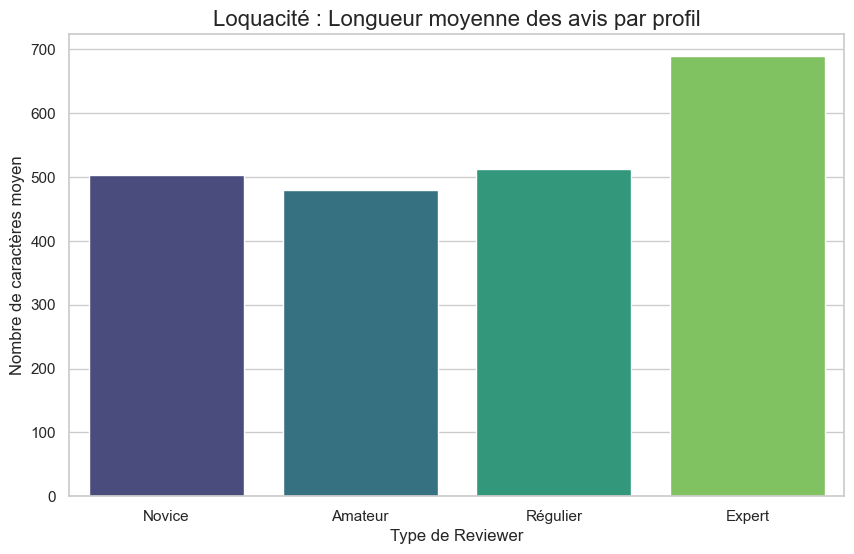

In [5]:
loquacity = df_merged.groupby('reviewer_type')['text_length'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=loquacity, x='reviewer_type', y='text_length', order=order, palette='viridis')
plt.title('Loquacité : Longueur moyenne des avis par profil', fontsize=16)
plt.xlabel('Type de Reviewer')
plt.ylabel('Nombre de caractères moyen')
plt.savefig('../outputs/figures/sae67_loquacity_by_profile.png')
plt.show()

## 5. Corrélation Average Stars (User) vs Review Count

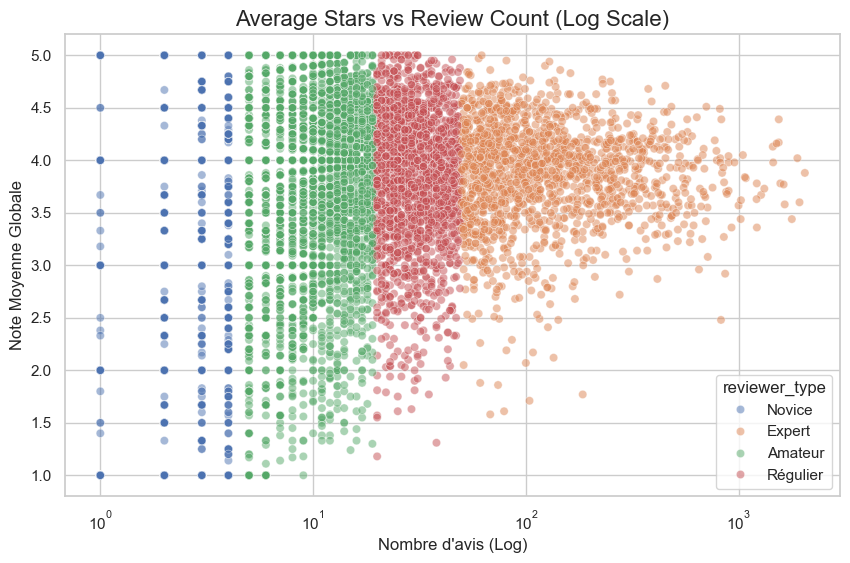

In [6]:
# On prend un sample des users pour le scatter plot sinon c'est illisible
df_users_sample = df_users.sample(10000, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_users_sample, x='review_count', y='average_stars', hue='reviewer_type', alpha=0.5)
plt.xscale('log')
plt.title('Average Stars vs Review Count (Log Scale)', fontsize=16)
plt.xlabel('Nombre d\'avis (Log)')
plt.ylabel('Note Moyenne Globale')
plt.savefig('../outputs/figures/sae67_stars_vs_experience.png')
plt.show()